# Analyse d'une serie chronologique avec RNN

Série simple à valeurs dans R (inspiré par MachineLearningMastery)

In [77]:
import numpy as np
import pandas as pd

In [79]:
df = pd.read_csv("Sunspots.csv")
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [81]:
df.shape

(3265, 3)

In [83]:
data = np.array(df['Monthly Mean Total Sunspot Number']
                .values
                .astype('float32'))

In [85]:
data.shape  # 1D

(3265,)

In [87]:
# convertir en matrice colonne pour l'apprentissage
data = data.reshape(-1, 1)   # nb de ligne -1: autant que neccessaire
data.shape

(3265, 1)

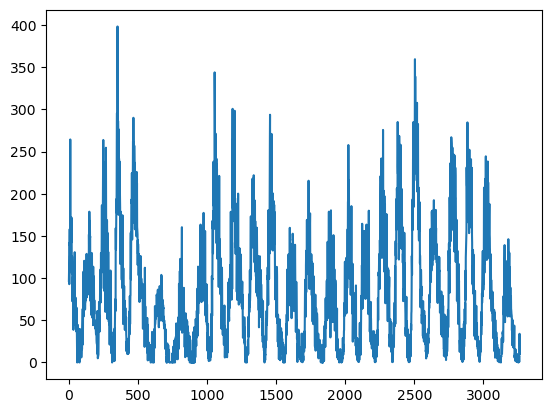

In [89]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.show()

In [91]:
# longeur d'une sequence a traiter :
# on prend 12 valeurs consécutives pour l'entree du reseau
# et on essaye de prevoir la suivante
time_steps = 12

In [93]:
# Normalisation dans [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [95]:
np.min(data), np.max(data)

(0.0, 1.0)

In [97]:
# train-test split
cut = int(0.8 * len(data))
train_data = data[ :cut]
test_data = data[cut: ]

In [99]:
train_data.shape, test_data.shape

((2612, 1), (653, 1))

In [101]:
# divisible par 12??
2612 / 12 # non ...

217.66666666666666

In [103]:
# or , ici le nombre de pas égal à 12 (time steps) est fixé une fois pour toutes, 
# . c.a.d on ne peut pas le changer durant l'apprentissagz
# Par consequent, on doit tailler les données (couper la derniere sequence qui est incomplète)

2612 // 12 # on aura 217 "parquets" de 12 observations 

217

In [105]:
# préparation des données : découpage en mini-séquences de 12
# les indices de 12 en 12
ind_y = np.arange(time_steps, len(train_data), time_steps)
print(ind_y)

[  12   24   36   48   60   72   84   96  108  120  132  144  156  168
  180  192  204  216  228  240  252  264  276  288  300  312  324  336
  348  360  372  384  396  408  420  432  444  456  468  480  492  504
  516  528  540  552  564  576  588  600  612  624  636  648  660  672
  684  696  708  720  732  744  756  768  780  792  804  816  828  840
  852  864  876  888  900  912  924  936  948  960  972  984  996 1008
 1020 1032 1044 1056 1068 1080 1092 1104 1116 1128 1140 1152 1164 1176
 1188 1200 1212 1224 1236 1248 1260 1272 1284 1296 1308 1320 1332 1344
 1356 1368 1380 1392 1404 1416 1428 1440 1452 1464 1476 1488 1500 1512
 1524 1536 1548 1560 1572 1584 1596 1608 1620 1632 1644 1656 1668 1680
 1692 1704 1716 1728 1740 1752 1764 1776 1788 1800 1812 1824 1836 1848
 1860 1872 1884 1896 1908 1920 1932 1944 1956 1968 1980 1992 2004 2016
 2028 2040 2052 2064 2076 2088 2100 2112 2124 2136 2148 2160 2172 2184
 2196 2208 2220 2232 2244 2256 2268 2280 2292 2304 2316 2328 2340 2352
 2364 

In [107]:
# arrange a fait le travail d'ajustement
217 * 12

2604

In [109]:
# on selectionne les observations aux moments donnés par y_ind
y_train = train_data[ind_y]  # observation à predire

In [111]:
y_train.shape

(217, 1)

In [113]:
# tableaux de 217 séquences d'apprentissage de taille (217, 12)
rows_x = len(ind_y)   # 217

# on découpe 217*12 premiers elements (pour avoir une bonne longeur)
x_tmp = train_data[range(time_steps * rows_x)]

x_train = x_tmp.reshape(rows_x, time_steps, 1)  # (217, 12, 1) , ou "1" est la dimension d'une seules observation (=R^1, scalaire)

In [115]:
# test / confirmation 
x_train.shape

(217, 12, 1)

In [120]:
# meme chose pour l'ensemble de test
ind_yy = np.arange(time_steps, len(test_data), time_steps)   # on pourrait ecrire une fonction 

y_test = test_data[ind_yy]
rows_xx = len(ind_yy)
x_tmp = test_data[0:time_steps*rows_xx]
x_test = x_tmp.reshape(rows_xx, time_steps, 1)
x_test.shape

(54, 12, 1)

In [122]:
54*12 , len(test_data), len(test_data)//12

(648, 653, 54)

# RNN avec Keras

In [124]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras import Input
from sklearn.metrics import mean_squared_error

In [128]:
model = Sequential([
    Input(shape=(time_steps, 1)),   # 1 ici est la dimensionnalite d'une observation
    SimpleRNN(units=3, activation ='tanh'),
    Dense(units=1, activation ='tanh')   # une regression dans [-1, 1]
])

In [130]:
model.compile(loss='mse', optimizer='adam')

In [132]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 19 (76.00 B)

 Non-trainable params: 0 (0.00 B)

In [134]:
model.fit(x_train,
          y_train,
          epochs=20,
          batch_size=1)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.0654 
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0082
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 0.0071
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 0.0090
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 0.0066 
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 0.0060
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 0.0063
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 0.0046 
Epoch 9/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0055
Epoch 10/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 0.0057
Epoch 11/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0050 
Epoch 12/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.0052
Epoch 13/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 0.0050 
Epoch 14/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.0058 
Epoch 15/20
217/217 ━━━

In [136]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [138]:
train_pred.shape

(217, 1)

In [140]:
test_pred.shape

(54, 1)

In [144]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

In [146]:
train_rmse, test_rmse

(0.07061615, 0.08340685)

In [148]:
# pour apprecier ce resultat il faut revenir a l'echelle d'origine
df.describe()

,Unnamed: 0,Monthly Mean Total Sunspot Number
count,3265.000000,3265.000000
mean,1632.000000,81.778775
std,942.668641,67.889277
min,0.000000,0.000000
25%,816.000000,23.900000
50%,1632.000000,67.200000
75%,2448.000000,122.500000
max,3264.000000,398.200000


In [152]:
nmax = 398.2  # nombre max de taches, correspond a 1 dans x_train

In [154]:
train_rmse * nmax  # pas trop , mais pas cata non plus

28.11935029774904

In [156]:
test_rmse * nmax  # sur l'ensemble de test reste assez similaire, pas grand prob. de surapp.
# le resultat reste acceptable

33.212607946991916

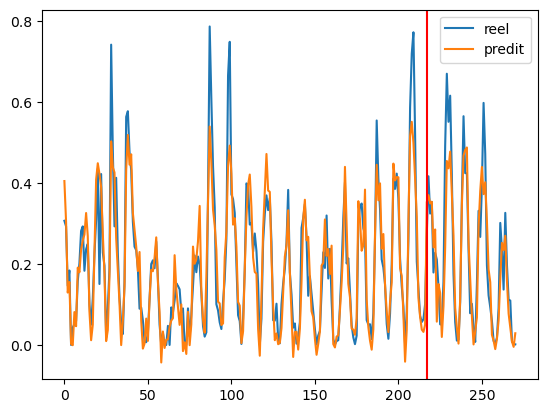

In [158]:
# Visualisation 
reel = np.append(y_train, y_test)
predit = np.append(train_pred, test_pred)
rows = len(reel)
plt.plot(range(rows), reel, label = 'reel')
plt.plot(range(rows), predit, label='predit')

# marquer la ligne de partage entre x_train et x_test
plt.axvline(x=len(y_train), color = 'r')
plt.legend()
plt.show()